Simulation of dark cycle done. 
 kin: 0.024 
 mean_period: 21.596009600960095
 Number of periods inside the stable range: 4


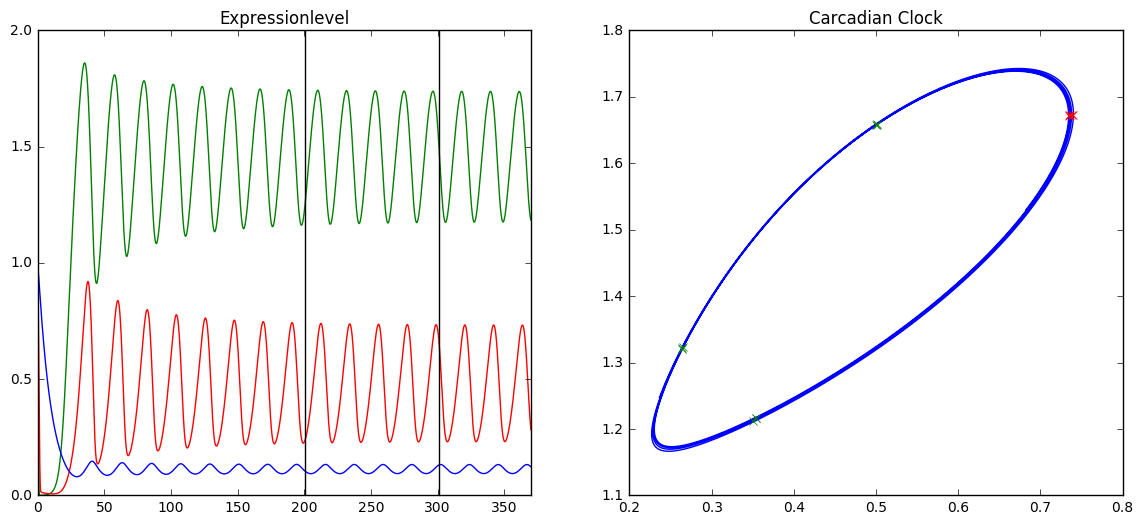

C:\Users\Iffat ara mahfuz\Anaconda3\lib\site-packages\ipykernel\__main__.py:177: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Simulation of 12h cycle done. 
 Vsstep: 0.5 
 mean_period: 24.008934226756015
 Number of periods inside the stable range: 3


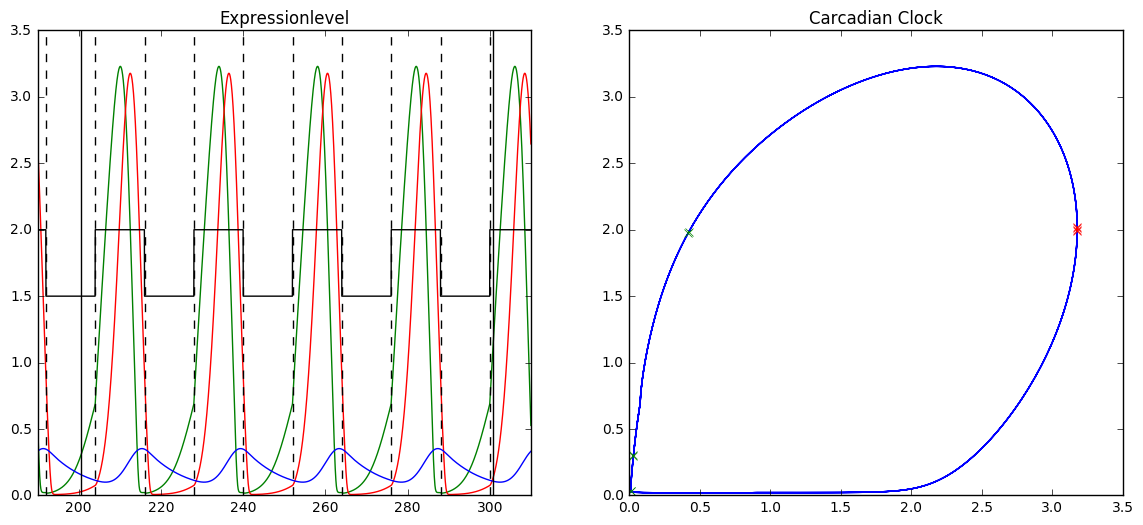

 Simulation of REVERSED 12h cycle done. 
 Vsstep: 0.5 
 mean_period: 24.008934226756008
 Number of periods inside the stable range: 3


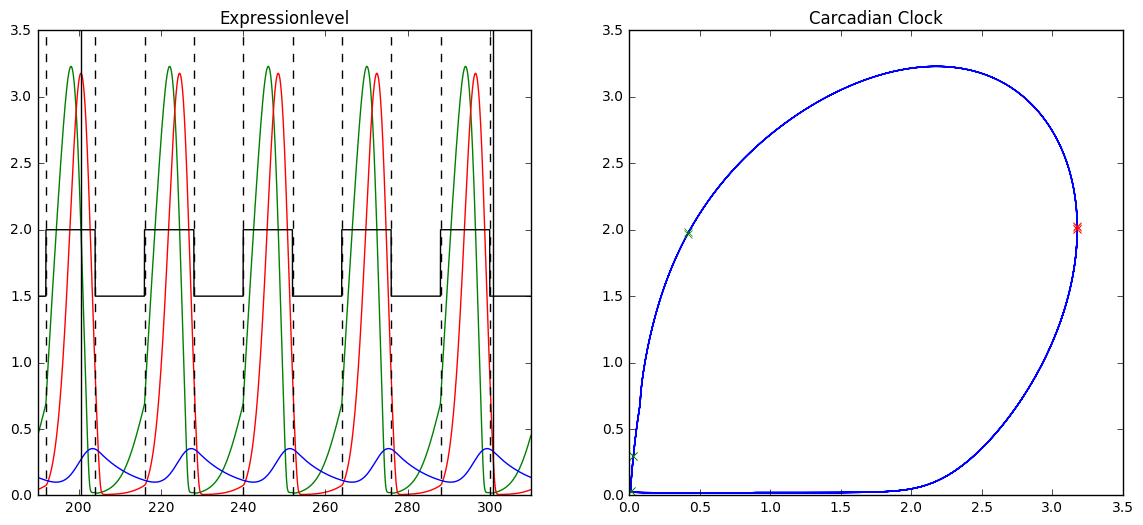

Simulation of 12h cycle done. 
 Vsstep: 0.15 
 mean_period: 24.008934226756015
 Number of periods inside the stable range: 3


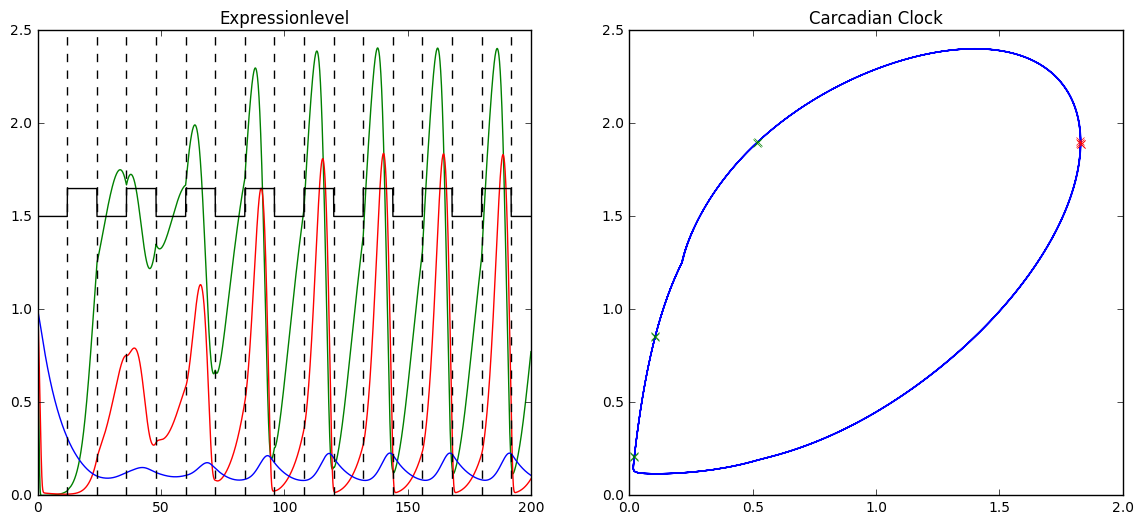

 Simulation of REVERSED 12h cycle done. 
 Vsstep: 0.15 
 mean_period: 24.0022502250225
 Number of periods inside the stable range: 4


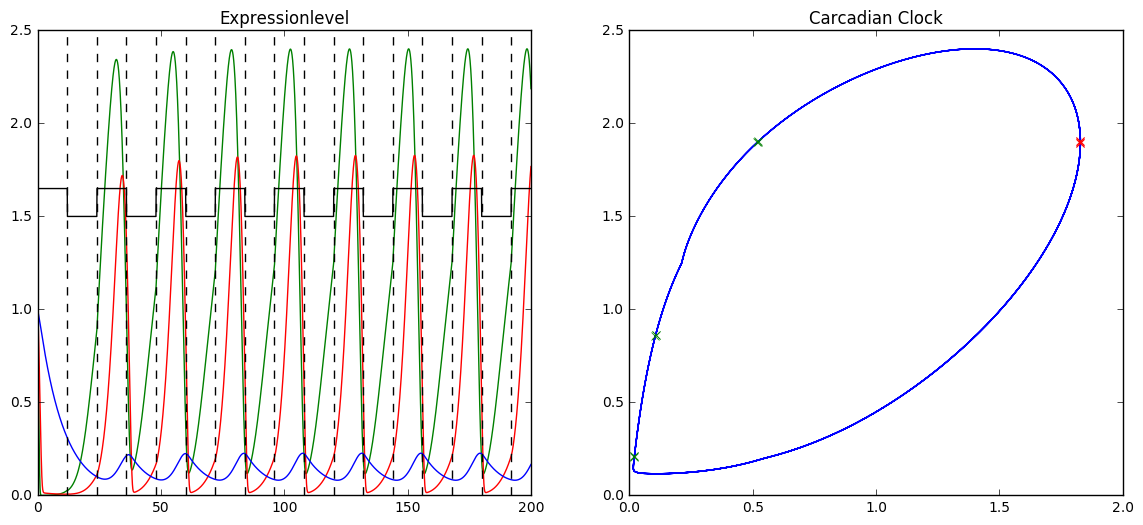

 Simulation of 16h cycle done. 
 Vsstep: 0.15 
 mean_period: 24.022302230223033
 Number of periods inside the stable range: 3


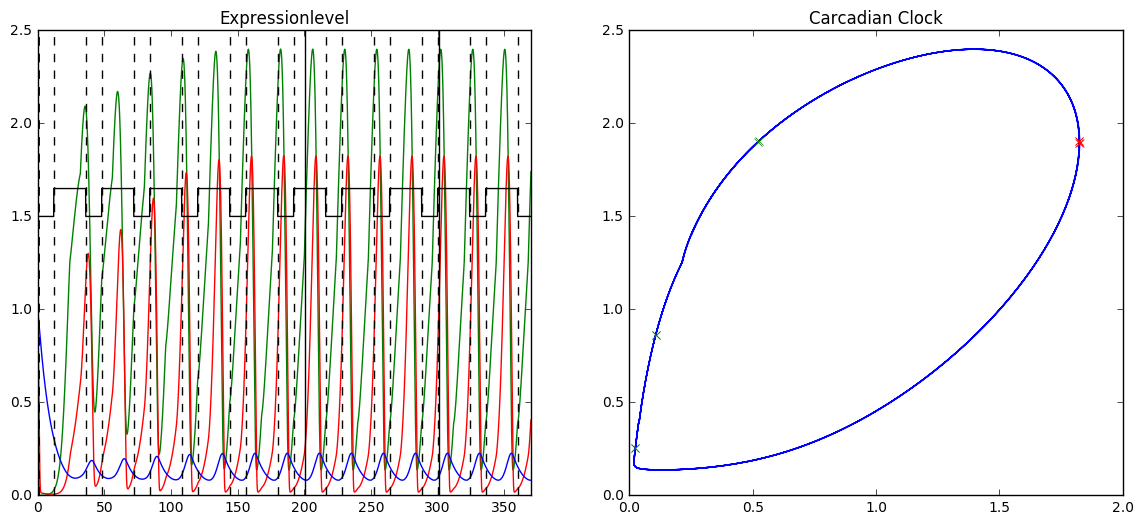

In [2]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema


def func1 (Vs, K, Fn, Vm, M, Km, n):
    return (Vs * ((K**n)/((K**n)+(Fn**n))) - (Vm * (M/(Km+M))))

def func2 (ks, M, Vd, Fc, Kd, Fn, kin, kout):
    return ks*M - Vd * (Fc/(Kd+Fc)) - kin * Fc + kout * Fn

def func3 (kin, Fc, kout, Fn):
    return kin * Fc - kout * Fn

def equation_system (args,t):

    M,Fc,Fn = args

    Mnew = func1(Vs, K, Fn, Vm, M, Km,n)
    Fcnew = func2(ks, M, Vd, Fc, Kd, Fn, kin, kout)
    Fnnew = func3 (kin, Fc, kout, Fn)

    return (Mnew, Fcnew, Fnnew)

def equation_system_12h (args,t):

    M,Fc,Fn = args

    ## now extract from t the hour
    hours = int(t)
    daytime = int(hours / 12)
    if (daytime % 2 == 0):
        #its night
        Vs=1.5
    else:
        #it'sday
        Vs=1.5+Vsstep

    Mnew = func1(Vs, K, Fn, Vm, M, Km,n)
    Fcnew = func2(ks, M, Vd, Fc, Kd, Fn, kin, kout)
    Fnnew = func3 (kin, Fc, kout, Fn)
    return (Mnew, Fcnew, Fnnew)

def equation_system_12h_reverse (args,t):

    M,Fc,Fn = args

    ## now extract from t the hour
    hours = int(t)
    daytime = int(hours / 12)
    if (daytime % 2 == 1):
        #its night
        Vs=1.5
    else:
        #it'sday
        Vs=1.5+Vsstep

    Mnew = func1(Vs, K, Fn, Vm, M, Km,n)
    Fcnew = func2(ks, M, Vd, Fc, Kd, Fn, kin, kout)
    Fnnew = func3 (kin, Fc, kout, Fn)
    return (Mnew, Fcnew, Fnnew)



def equation_system_16h (args,t):

    M,Fc,Fn = args

    ## now extract from t the hour
    hours = int(t)
    daytime = int(hours / 8)
    if (daytime % 3 == 0):
        #its night
        Vs=1.5
    else:
        #it's day
        Vs=1.5+Vsstep

    Mnew = func1(Vs, K, Fn, Vm, M, Km,n)
    Fcnew = func2(ks, M, Vd, Fc, Kd, Fn, kin, kout)
    Fnnew = func3 (kin, Fc, kout, Fn)

    return (Mnew, Fcnew, Fnnew)

Vs = 1.5
Vm = 1.5
Vd = 1.0
ks = 0.5
K = 0.2
Km = 0.15
Kd = 0.15
kout = 0.1
n = 4


kin = 0.02
Vsstep = 0.5

hours = 400
step = 10000
start = 0
end = hours + start + 1


start_m = 1
start_fc = 1
start_fn = 1
min_stable = int(step/2)
max_stable = int((step/4)*3)


def simulation(functionname,plot_vs,plot_vs_reverse=False,xlim=[0,370],plot_16h=False):
    t = np.linspace(start,end,step)
    solution = integrate.odeint(functionname,(start_m,start_fc,start_fn),t)
    stable_solution = solution[min_stable:max_stable]
    stable_t = t[min_stable:max_stable]
    #find the index of all local maxima in stable area
    time = argrelextrema(stable_solution[:,1], np.greater)[0]
    periods = np.zeros(len(time))
    periods[0] = stable_t[time[0]]
    for i in range(1,len(time)):
        periods[i] = (stable_t[time[i]]-stable_t[time[i-1]])
    periods = periods[1:]
    sum = np.sum(periods)
    meanperiod = sum / len(periods)
    #print(periods)

    quarters = periods / 4
    quarters = quarters[1:-1]
    mean_quarters = np.sum(quarters) / len(quarters)

    ##get daytimes
    evening = stable_t[time[1:-1]]
    midnight = np.zeros(len(evening))
    morning = np.zeros(len(evening))
    noon = np.zeros(len(evening))

    for i in range(len(evening)):
        midnight[i] = evening[i] + (mean_quarters * 1)
        morning[i] = evening[i] + (mean_quarters * 2)
        noon[i] = evening[i] + (mean_quarters * 3)

    ### find from the caluculated the next real time step we have
    for i in range(len(evening)):
        midnight[i] = np.where(midnight[i] > stable_t)[0][-1]
        morning[i] = np.where(morning[i] > stable_t)[0][-1]
        noon[i] = np.where(noon[i] > stable_t)[0][-1]


    midnight = midnight.astype(np.int, copy=False)
    morning = morning.astype(np.int, copy=False)
    noon = noon.astype(np.int, copy=False)
    evening = time[:]

    midnight_level = stable_solution[midnight]
    morning_level = stable_solution[morning]
    noon_level = stable_solution[noon]
    evening_level = stable_solution[evening]

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(14, 6), dpi=360)
    axes[0].plot(t, solution[:,0], "green", t, solution[:,1], "red", t, solution[:,2], "blue")
    axes[0].axvline(t[min_stable], color='black', linestyle='-')
    axes[0].axvline(t[max_stable], color='black', linestyle='-')
    axes[0].set_title("Expressionlevel")
    axes[0].set_xlim(xlim)

    axes[1].plot(stable_solution[:,1], stable_solution[:,0])
    axes[1].plot(evening_level[:,1], evening_level[:,0],linestyle ='solid',marker = 'x', color='Red')
    axes[1].plot(midnight_level[:,1], midnight_level[:,0],linestyle ='solid',marker = 'x', color='green')
    axes[1].plot(noon_level[:,1], noon_level[:,0],linestyle ='solid',marker = 'x', color='green')
    axes[1].plot(morning_level[:,1], morning_level[:,0],linestyle ='solid',marker = 'x', color='green')
    axes[1].set_title("Carcadian Clock")

    if plot_vs:
        Vs_level = np.zeros(len(t))
        Vs_switch = np.zeros(hours/12)
        Vs_switch_counter = 0
        if not plot_16h:
            if not plot_vs_reverse:
                for i in range(len(t)):
                    hour = int(t[i])
                    daytime = int(hour / 12)
                    if (daytime % 2 == 0):
                        #its night
                        Vs_level[i]=1.5
                        if Vs_level[i-1] == 1.5+Vsstep:
                            Vs_switch[Vs_switch_counter] = t[i]
                            Vs_switch_counter += 1
                    else:
                        #it'sday
                        Vs_level[i]=1.5+Vsstep
                        if Vs_level[i-1] == 1.5:
                            Vs_switch[Vs_switch_counter] = t[i]
                            Vs_switch_counter += 1
            else:
                for i in range(len(t)):
                    hour = int(t[i])
                    daytime = int(hour / 12)
                    if (daytime % 2 == 1):
                        #its night
                        Vs_level[i]=1.5
                        if Vs_level[i-1] == 1.5+Vsstep:
                            Vs_switch[Vs_switch_counter] = t[i]
                            Vs_switch_counter += 1
                    else:
                        #it'sday
                        Vs_level[i]=1.5+Vsstep
                        if Vs_level[i-1] == 1.5:
                            Vs_switch[Vs_switch_counter] = t[i]
                            Vs_switch_counter += 1
        else:
            for i in range(len(t)):
                hour = int(t[i])
                daytime = int(hour / 12)
                if (daytime % 3 == 0):
                    #its night
                    Vs_level[i]=1.5
                    if Vs_level[i-1] == 1.5+Vsstep:
                        Vs_switch[Vs_switch_counter] = t[i]
                        Vs_switch_counter += 1
                else:
                    #it'sday
                    Vs_level[i]=1.5+Vsstep
                    if Vs_level[i-1] == 1.5:
                        Vs_switch[Vs_switch_counter] = t[i]
                        Vs_switch_counter += 1

        axes[0].plot(t, Vs_level, "black")
        for i in Vs_switch:
            axes[0].axvline(i, color='k', linestyle='--')





    return (meanperiod, periods)


#### Task 2 find kin value which results in period of 21.5h

kin = 0.024  ### default was 0.02
meanperiod, periods = simulation(equation_system,plot_vs=False)
print("Simulation of dark cycle done. \n kin: {0} \n mean_period: {1}".format(kin,meanperiod))
print(" Number of periods inside the stable range: {0}".format((len(periods))))
#plt.savefig('C:/plot/fig1.png')
plt.show()

#### Task 3 run 12h light cycle
Vsstep = 0.5
meanperiod, periods = simulation(equation_system_12h,plot_vs=True,xlim=[190,310])
print("Simulation of 12h cycle done. \n Vsstep: {0} \n mean_period: {1}".format(Vsstep,meanperiod))
print(" Number of periods inside the stable range: {0}".format((len(periods))))
#plt.savefig('C:/plot/fig2.png')
plt.show()

###  Task 3 run 12h light cycle with different start
meanperiod, periods = simulation(equation_system_12h_reverse,plot_vs=True,plot_vs_reverse=True,xlim=[190,310])
print(" Simulation of REVERSED 12h cycle done. \n Vsstep: {0} \n mean_period: {1}".format(Vsstep,meanperiod))
print(" Number of periods inside the stable range: {0}".format((len(periods))))
#plt.savefig('C:/plot/fig3.png')
plt.show()


### Task 3 run 12h light cycle with minimal vsstep which still have a 24h period
Vsstep = 0.15
meanperiod, periods = simulation(equation_system_12h,plot_vs=True,xlim=[0,200])
print("Simulation of 12h cycle done. \n Vsstep: {0} \n mean_period: {1}".format(Vsstep,meanperiod))
print(" Number of periods inside the stable range: {0}".format((len(periods))))
#plt.savefig('C:/plot/fig4.png')
plt.show()

### Task 3 run 12h light cycle with minimal vsstep which still have a 24h period and different start
meanperiod, periods = simulation(equation_system_12h_reverse,plot_vs=True,plot_vs_reverse=True,xlim=[0,200])
print(" Simulation of REVERSED 12h cycle done. \n Vsstep: {0} \n mean_period: {1}".format(Vsstep,meanperiod))
print(" Number of periods inside the stable range: {0}".format((len(periods))))
plt.show()


### Task 4 run 16h light cycle with minimal vsstep which still have a 24h period
meanperiod, periods = simulation(equation_system_16h, plot_vs=True, plot_16h=True)
print(" Simulation of 16h cycle done. \n Vsstep: {0} \n mean_period: {1}".format(Vsstep,meanperiod))
print(" Number of periods inside the stable range: {0}".format((len(periods))))
plt.show()
